In [1]:
# Setup access to my Google Drive
from google.colab import drive
drive.mount('/content/drive',  force_remount=False)

# Set the working directory
import os
os.chdir('/content/drive/MyDrive/ViT_myWorks/')
import warnings
warnings.filterwarnings("ignore")

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [2]:
!pip install -q torchmetrics

In [3]:
from sklearn.manifold import TSNE
from sklearn.metrics import f1_score, precision_score, recall_score
import matplotlib.pyplot as plt
import pandas as pd
import seaborn as sn
import numpy as np
import random
import torch
import torch.nn as nn
import torchvision.transforms as transforms
from torchvision.utils import make_grid
from torch.utils.data import Dataset, DataLoader
from torchmetrics import ConfusionMatrix
import PIL.Image as Image
device = torch.device("cuda:0" if (torch.cuda.is_available()) else "cpu")
import math
import scipy.io as sio

In [4]:
!ln -s '/content/drive/MyDrive/ViT_myWorks/cwruData' '/content/'

In [5]:
#Use following for case-1 dataset study
tarData = ['src_7_0'];

folderToSave = './saved_models'

In [6]:
tar = 0
root = '/content/cwruData/' + tarData[tar] + '/'

classNames = ['n', 'ir', 'b', 'or']

numClass = len(classNames)
label_map = {i : className for i, className in enumerate(classNames)}
print(f'\nLabels are mapped as\n {label_map}')


Labels are mapped as
 {0: 'n', 1: 'ir', 2: 'b', 3: 'or'}


In [8]:
df = pd.DataFrame(columns = ['img', 'label'])
j=0
for i in label_map:
  img_path = os.path.join(root, label_map[i])
  for img in os.listdir(img_path):
    image = os.path.join(img_path, img)
    df  = df.append(pd.DataFrame({'img':[image], 'label': i}), ignore_index = True)
    j+=1
df.head()

,img,label
0,/content/cwruData/src_7_0/n/n210.png,0
1,/content/cwruData/src_7_0/n/n211.png,0
2,/content/cwruData/src_7_0/n/n212.png,0
3,/content/cwruData/src_7_0/n/n213.png,0
4,/content/cwruData/src_7_0/n/n214.png,0


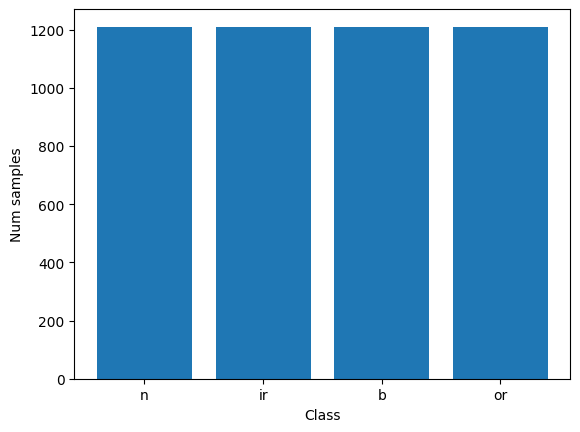

In [9]:
def vis_data_class_distribution(labels, class_names):
    #   labels: list of integers representing the class of each samples
    #   class_names: a list of class names corresponding to each class
    counts = [sum(labels == c) for c in range(len(class_names))]
    # plt.title(f'Data class distribution')
    plt.bar(class_names, counts)
    plt.xlabel('Class')
    plt.ylabel('Num samples')
    plt.show()

vis_data_class_distribution(df['label'],  classNames)

In [13]:
from sklearn.model_selection import train_test_split
Train, Test = train_test_split(df, test_size = 0.15, random_state = 42)
Train.head()

,img,label
765,/content/cwruData/src_7_0/n/n975.png,0
4292,/content/cwruData/src_7_0/or/or872.png,3
4209,/content/cwruData/src_7_0/or/or789.png,3
3172,/content/cwruData/src_7_0/b/b962.png,2
517,/content/cwruData/src_7_0/n/n727.png,0


In [25]:
class loadData(Dataset):
    def __init__(self, df):
      self.imgPath = df

    def __len__(self):
        return self.imgPath.shape[0]

    def __getitem__(self, idx):
        image_id = self.imgPath.iloc[idx,0]
        image = Image.open(image_id).convert("RGB")
        label = self.imgPath.iloc[idx,1]
        image = transform(image)
        return image, label

img_size=128
batch_size=16
transform = transforms.Compose(
          [transforms.ToTensor(),
           transforms.Resize(size=(img_size, img_size)),
          transforms.Normalize((1,1,1),(1, 1,1))
          ])

TrainLoader = DataLoader(loadData(Train), batch_size=batch_size, shuffle=True)
TestLoader = DataLoader(loadData(Test), batch_size=batch_size, shuffle=True)

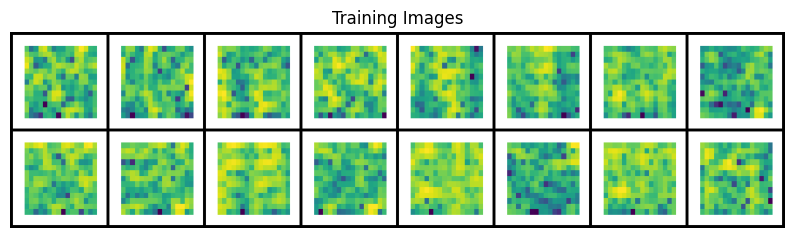

In [11]:
real_batch, label = next(iter(TrainLoader))
plt.figure(figsize=(10,5))
plt.axis("off")
plt.title("Training Images")
plt.imshow(np.transpose(make_grid(real_batch.to(device)[:16], padding=4, normalize=True).cpu(),(1,2,0)))

In [15]:
from sklearn.metrics import f1_score, precision_score, recall_score
import time
# Define validation loop
def validate(model, ValLoader):
    cm_metric = ConfusionMatrix(task = 'multiclass', num_classes=numClass).to(device)
    correct = 0
    total = 0
    tr_labels = np.array([])
    pred = np.array([])
    model.eval()
    with torch.no_grad():
        for data in ValLoader:
            inputs, labels = data[0].to(device), data[1].to(device)
            start_time = time.time()
            outputs = model(inputs)
            end_time = time.time()
            _, predicted = torch.max(outputs.data, 1)
            total += labels.size(0)
            correct += (predicted == labels).sum().item()
            cm_metric.update(predicted, labels)
            tr_labels = np.concatenate([tr_labels, labels.cpu().data.numpy()], axis=0)
            pred = np.concatenate([pred, predicted.cpu().data.numpy()], axis=0)
        cm = cm_metric.compute().detach().cpu().numpy()
    prec = precision_score(tr_labels, pred, average='macro')
    f1 = f1_score(tr_labels, pred, average='macro')
    rec = recall_score(tr_labels, pred, average='macro')
    return (correct / total) * 100, cm, prec, f1, rec, end_time-start_time

In [16]:
config = {
    "patch_size": 16,
    "hidden_size": 768,
    "num_hidden_layers": 12,  #Number of times to repeat encoder block
    "num_attention_heads": 4,
    "intermediate_size": 4 * 768, # 4 * hidden_size
    "hidden_dropout_prob": 0.1,
    "attention_probs_dropout_prob": 0.1,
    "initializer_range": 0.02,
    "image_size": img_size,
    "num_classes": numClass, # num_classes of CIFAR10
    "num_channels": 3,
    "qkv_bias": True,
    "use_faster_attention": True,
}
# These are not hard constraints, but are used to prevent misconfigurations
assert config["hidden_size"] % config["num_attention_heads"] == 0
assert config['intermediate_size'] == 4 * config['hidden_size']
assert config['image_size'] % config['patch_size'] == 0

In [17]:
class NewGELUActivation(nn.Module):
    """
    Implementation of the GELU activation function currently in Google BERT repo (identical to OpenAI GPT). Also see
    the Gaussian Error Linear Units paper: https://arxiv.org/abs/1606.08415
    Taken from https://github.com/huggingface/transformers/blob/main/src/transformers/activations.py
    """

    def forward(self, input):
        return 0.5 * input * (1.0 + torch.tanh(math.sqrt(2.0 / math.pi) * (input + 0.044715 * torch.pow(input, 3.0))))



In [18]:
class AttentionHead(nn.Module):
    """
    A single attention head.
    This module is used in the MultiHeadAttention module.
    """
    def __init__(self, hidden_size, attention_head_size, dropout, bias=True):
        super().__init__()
        self.hidden_size = hidden_size
        self.attention_head_size = attention_head_size
        # Create the query, key, and value projection layers
        self.query = nn.Linear(hidden_size, attention_head_size, bias=bias)
        #In above nn.Linear hidden_size is in_features in prior implementation(Transfer Learning) and attention_head_size is out_features in the same
        #In above command Linear means full connected without activation function but it has learnable weights and it is feed forward
        self.key = nn.Linear(hidden_size, attention_head_size, bias=bias)
        self.value = nn.Linear(hidden_size, attention_head_size, bias=bias)

        self.dropout = nn.Dropout(dropout)

    def forward(self, x):
        # (batch_size, sequence_length, hidden_size) -> (batch_size, sequence_length, attention_head_size)
        query = self.query(x)
        key = self.key(x)
        value = self.value(x)
        # softmax(Q*K.T/sqrt(head_size))*V
        attention_scores = torch.matmul(query, key.transpose(-1, -2))
        # print('shape of matmul of Q & K', attention_scores.shape)
        attention_scores = attention_scores / math.sqrt(self.attention_head_size)
        attention_probs = nn.functional.softmax(attention_scores, dim=-1)
        attention_probs = self.dropout(attention_probs)
        attention_output = torch.matmul(attention_probs, value)
        return (attention_output, attention_probs)


In [19]:
class MultiHeadAttention(nn.Module):
    """
    Multi-head attention module.
    This module is used in the TransformerEncoder module.
    """

    def __init__(self, config):
        super().__init__()
        self.hidden_size = config["hidden_size"]
        self.num_attention_heads = config["num_attention_heads"]
        # The attention head size is the hidden size divided by the number of attention heads
        # self.attention_head_size = self.hidden_size // self.num_attention_heads
        self.attention_head_size = self.hidden_size
        self.all_head_size = self.num_attention_heads * self.attention_head_size
        # Whether or not to use bias in the query, key, and value projection layers
        self.qkv_bias = config["qkv_bias"]
        # Create a list of attention heads
        self.heads = nn.ModuleList([])
        for _ in range(self.num_attention_heads):
            head = AttentionHead(
                self.hidden_size,
                self.attention_head_size,
                config["attention_probs_dropout_prob"],
                self.qkv_bias
            )
            self.heads.append(head)
            #The above line appends the heads to the list named self.heads
        # Create a linear layer to project the attention output back to the hidden size
        # In most cases, all_head_size and hidden_size are the same
        self.output_projection = nn.Linear(self.all_head_size, self.hidden_size)
        self.output_dropout = nn.Dropout(config["hidden_dropout_prob"])

    def forward(self, x, output_attentions=True):
        # Calculate the attention output for each attention head
        attention_outputs = [head(x) for head in self.heads]
        # Concatenate the attention outputs from each attention head
        stack_prob = torch.stack([attention_prob for _, attention_prob in attention_outputs])
        ref_prob = torch.zeros(stack_prob[0].shape)
        ref_prob = ref_prob.to(device)
        diff = torch.tensor([torch.sum(torch.abs(stack_prob[i]-ref_prob)) for i in range(stack_prob.shape[0])])
        _, best_prob_indx = torch.sort(diff, dim = 0, descending=True)
        best_prob_indx = best_prob_indx.to(device)
        # print('The best attn prob', stack_prob[best_prob_indx[0]].shape)
        attention_best, _ = attention_outputs[best_prob_indx[0]]
        attention_output = torch.cat([attention_output for attention_output, _ in attention_outputs], dim=-1)

        #Here dim=-1 means ignoring the dimension
        # Project the concatenated attention output back to the hidden size
        attention_output = self.output_projection(attention_output)
        attention_output = self.output_dropout(attention_output)
        attention_output = attention_output + attention_best
        return attention_output

In [20]:
class MyFC(nn.Module):
      def __init__(self):
          super(MyFC,self).__init__()
          self.clf=nn.Sequential(
              nn.Flatten(),
              nn.Linear(768,256),
              nn.ReLU(),
            #   nn.Linear(256,128),
            #   nn.ReLU(),
              nn.Dropout(0.4),
              nn.Linear(256,numClass)
          )
      def forward(self,x):
          return self.clf(x)

In [21]:
!pip install --upgrade pytorch-pretrained-vit
from pytorch_pretrained_vit import ViT

  Preparing metadata (setup.py) ... done
  Created wheel for pytorch-pretrained-vit: filename=pytorch_pretrained_vit-0.0.7-py3-none-any.whl size=11116 sha256=aa88eeccab1a6d869899251f6a4b6ca69803183f750ddd05a8ada815092436c3
  Stored in directory: /root/.cache/pip/wheels/2d/46/ad/12007be9d377d0fbf27ef75b6e47ed92832ab6b70dbf004b6f
Successfully built pytorch-pretrained-vit


In [30]:
from sklearn.metrics import ConfusionMatrixDisplay
def disp_conf_matrix(cm, class_names = ['N', 'IR', 'B', 'OR']):
    fig, ax = plt.subplots(figsize=(8,6))
    ConfusionMatrixDisplay(cm, display_labels = class_names).plot(ax=ax)

In [22]:
Model = ViT('B_16_imagenet1k', image_size = img_size, num_classes = numClass, pretrained=True)
# torch.save(Model.state_dict(), './saved_models/vit_pretrained.pth')
Model.fc=MyFC()
for i in range(config['num_hidden_layers']):
    Model.transformer.blocks[i].attn = MultiHeadAttention(config)

Downloading: "https://github.com/lukemelas/PyTorch-Pretrained-ViT/releases/download/0.0.2/B_16_imagenet1k.pth" to /root/.cache/torch/hub/checkpoints/B_16_imagenet1k.pth
100%|██████████| 331M/331M [00:07<00:00, 48.5MB/s]


Resized positional embeddings from torch.Size([1, 577, 768]) to torch.Size([1, 65, 768])
Loaded pretrained weights.


In [23]:
#Define optimizer and loss
optC = torch.optim.Adam(Model.parameters(), lr=0.00001)
criterion = nn.CrossEntropyLoss()

In [26]:
# Main Traiing loop
num_epochs=20
tr_Losses = []
Model.to(device)

print("Starting Training Loop...")
for epoch in range(num_epochs):
      Model.train()
      running_loss = 0.0
      total_train = 0
      correct_train = 0
      for i, data in enumerate(TrainLoader, 0):
            inputs, labels = data[0].to(device), data[1].to(device)

            torch.autograd.set_detect_anomaly(True)
            optC.zero_grad()
            predictions = Model(inputs)
            ClassifierLoss = criterion(predictions, labels)
            ClassifierLoss.backward(retain_graph=True)
            optC.step()


      train_acc, _,_,_,_, _ = validate(Model, TrainLoader)
      tr_Losses.append(ClassifierLoss.item())
      val_acc, _,_,_,_, _ = validate(Model, TestLoader)
      text = (f'{epoch}/{num_epochs}: Train Accuracy = {train_acc}%,  Val Accuracy = {val_acc}%')
      print('[%d/%d]   Train Accuracy = %.2f    Val Accuracy = %.2f'  %(epoch, num_epochs, train_acc, val_acc))
      Model.train()

Starting Training Loop...
[0/20]   Train Accuracy = 45.94    Val Accuracy = 49.04
[1/20]   Train Accuracy = 61.59    Val Accuracy = 65.56
[2/20]   Train Accuracy = 61.50    Val Accuracy = 60.19
[3/20]   Train Accuracy = 76.35    Val Accuracy = 77.96
[4/20]   Train Accuracy = 68.01    Val Accuracy = 71.76
[5/20]   Train Accuracy = 87.43    Val Accuracy = 87.19
[6/20]   Train Accuracy = 90.67    Val Accuracy = 90.22
[7/20]   Train Accuracy = 93.32    Val Accuracy = 90.77
[8/20]   Train Accuracy = 90.93    Val Accuracy = 88.43
[9/20]   Train Accuracy = 94.48    Val Accuracy = 92.84
[10/20]   Train Accuracy = 94.70    Val Accuracy = 92.84
[11/20]   Train Accuracy = 92.93    Val Accuracy = 90.50
[12/20]   Train Accuracy = 97.98    Val Accuracy = 96.01
[13/20]   Train Accuracy = 96.23    Val Accuracy = 92.98
[14/20]   Train Accuracy = 96.89    Val Accuracy = 94.77
[15/20]   Train Accuracy = 94.90    Val Accuracy = 92.42
[16/20]   Train Accuracy = 96.99    Val Accuracy = 95.04
[17/20]   Train

In [32]:
print("Continue Training Loop...")
num_epochs=10
for epoch in range(num_epochs):
      Model.train()
      running_loss = 0.0
      total_train = 0
      correct_train = 0
      for i, data in enumerate(TrainLoader, 0):
            inputs, labels = data[0].to(device), data[1].to(device)

            torch.autograd.set_detect_anomaly(True)
            optC.zero_grad()
            predictions = Model(inputs)
            ClassifierLoss = criterion(predictions, labels)
            ClassifierLoss.backward(retain_graph=True)
            optC.step()


      train_acc, _,_,_,_, _ = validate(Model, TrainLoader)
      tr_Losses.append(ClassifierLoss.item())
      val_acc, _,_,_,_, _ = validate(Model, TestLoader)
      text = (f'{epoch}/{num_epochs}: Train Accuracy = {train_acc}%,  Val Accuracy = {val_acc}%')
      print('[%d/%d]   Train Accuracy = %.2f    Val Accuracy = %.2f'  %(epoch, num_epochs, train_acc, val_acc))
      Model.train()

Continue Training Loop...
[0/10]   Train Accuracy = 95.24    Val Accuracy = 92.98
[1/10]   Train Accuracy = 99.49    Val Accuracy = 96.14
[2/10]   Train Accuracy = 98.98    Val Accuracy = 95.73
[3/10]   Train Accuracy = 99.66    Val Accuracy = 97.11
[4/10]   Train Accuracy = 99.47    Val Accuracy = 96.28
[5/10]   Train Accuracy = 99.81    Val Accuracy = 96.83
[6/10]   Train Accuracy = 99.64    Val Accuracy = 95.59
[7/10]   Train Accuracy = 98.86    Val Accuracy = 95.18
[8/10]   Train Accuracy = 99.88    Val Accuracy = 97.38
[9/10]   Train Accuracy = 99.61    Val Accuracy = 96.14


In [33]:
torch.save(Model,'./saved_models/ViT_'+tarData[tar]+'.pth')

In [ ]:
Model = torch.load('./saved_models/ViT_'+tarData[tar]+'.pth', map_location=device)

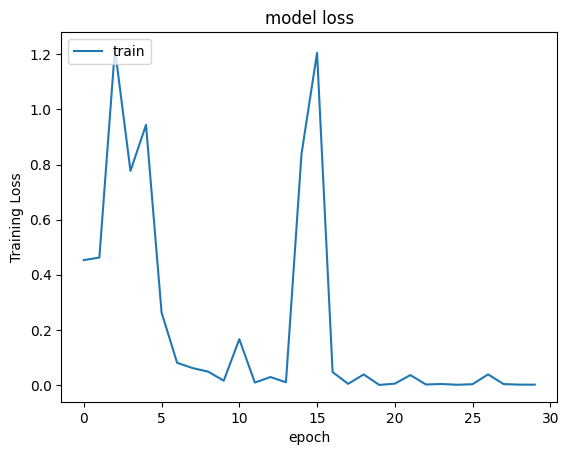

In [37]:
trloss=np.array(tr_Losses)
plt.plot(trloss)
plt.title('model loss')
plt.ylabel('Training Loss')
plt.xlabel('epoch')
plt.legend(['train'], loc='upper left')
plt.show()

Validation Accuracy =  96.28099173553719
__________________________________________________
Pricision Score = 0.9632788975593447
__________________________________________________
F_1 Score =  0.9616832661150403
__________________________________________________
Recall Score =  0.9620916880036356
__________________________________________________
Response time per batch 0.02749919891357422


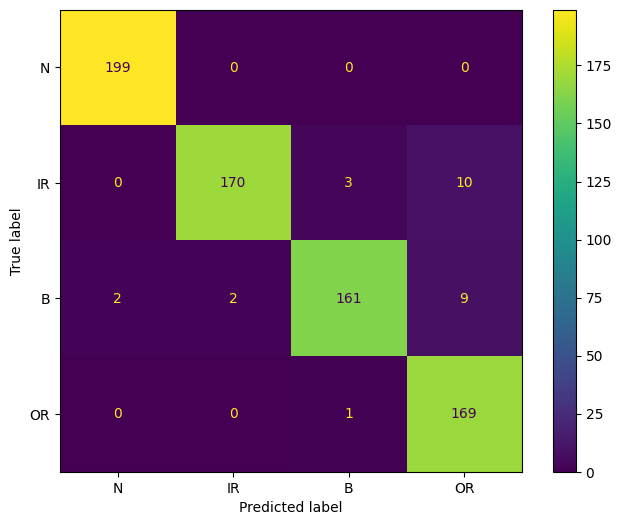

In [36]:
# Validate and Visualize
val_acc, cm, prec, f1, recall, time_batch = validate(Model, TestLoader)
print('Validation Accuracy = ', val_acc)
print("__________________________________________________")
print(f'Pricision Score = {prec}')
print('__________________________________________________')
print(f'F_1 Score =  {f1}')
print('__________________________________________________')
print(f"Recall Score =  {recall}")
print('__________________________________________________')
print('Response time per batch', time_batch)
disp_conf_matrix(cm)

perfData = {'Modelname':['ViT_attn'+tarData[tar]], 'Val Acc.': val_acc, 'Precision':prec, 'F1_score':f1, 'Recall':recall}

In [38]:
perfData = pd.DataFrame(perfData)
# perfData.to_csv('results_'+ tarData[tar]+ '.csv')
perfData

,Modelname,Val Acc.,Precision,F1_score,Recall
0,ViT_attnsrc_7_0,96.280992,0.963279,0.961683,0.962092
